# Аналіз результатів ЗНО-2019

У цьому блокноті наведені міркування щодо [результатів ЗНО-2019](https://zno.testportal.com.ua/opendata) з числовими
обґрунтуваннями. Вважаємо, що README.md вже прочитано, тож необхідні пакети встановлені, а файли з даними — стягнуті.

In [1]:
from IPython.display import HTML, display
from matplotlib.pyplot import subplots
from numpy import where
from pandas import DataFrame, read_csv, cut, concat
from scipy.stats import ttest_ind
from seaborn import set_style, barplot, histplot, heatmap, color_palette, boxplot
from tqdm.auto import tqdm

In [2]:
set_style('darkgrid')

## Читання CSV

Pandas має правильно розпарсити вхідні табличні дані, тож задаємо йому коректний роздільник, виправляємо імена колонок
та типи даних. Також потрібно вказати кодування тексту, чия обробка не на Windows спричинить помилку.

In [3]:
column_types = {
    'fraDPALevel': str,
    'spaTest': str,
    'spaTestStatus': str,
    'spaBall100': str,
    'spaDPALevel': str,
    'spaPTName': str,
    'spaPTRegName': str,
    'spaPTAreaName': str,
    'spaPTTerName': str
}

In [4]:
column_renamings = {'HistLang': 'histLang'}

In [5]:
ife = (
    read_csv('data/Odata2019File.csv', sep=';', encoding='windows-1251', dtype=column_types)
    .rename(columns=column_renamings)
)

In [6]:
ife.info(verbose=True, show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353813 entries, 0 to 353812
Data columns (total 126 columns):
 #    Column            Non-Null Count   Dtype  
---   ------            --------------   -----  
 0    OUTID             353813 non-null  object 
 1    Birth             353813 non-null  int64  
 2    SEXTYPENAME       353813 non-null  object 
 3    REGNAME           353813 non-null  object 
 4    AREANAME          353813 non-null  object 
 5    TERNAME           353813 non-null  object 
 6    REGTYPENAME       353813 non-null  object 
 7    TerTypeName       353813 non-null  object 
 8    ClassProfileNAME  319688 non-null  object 
 9    ClassLangName     319688 non-null  object 
 10   EONAME            319688 non-null  object 
 11   EOTYPENAME        319688 non-null  object 
 12   EORegName         319688 non-null  object 
 13   EOAreaName        319688 non-null  object 
 14   EOTerName         319688 non-null  object 
 15   EOParent          319688 non-null  object 
 16   

Як бачимо, вибірка включає дані 353813 учасників. Зі 126 колонок перші 16 описують самих учасників, решта — відповідні
предмети, результати й місця складання.

In [7]:
ife.shape

(353813, 126)

Колонка `OUTID` є достовірним ID для однозначного визначення анонімного учасника, тож використаємо її надалі, як
індекс.

In [8]:
ife['OUTID'].nunique()

353813

## Дані учасників

Вхідну таблицю слід нормалізувати на принаймні дві — людей та результати кожного іспиту. Нині формуємо першу.

In [9]:
participants = ife[ife.columns[:16]].fillna('').set_index('OUTID')

In [10]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 353813 entries, 07ad4c55-70ef-442d-bb7f-34c95c0e6ee4 to ae187ba1-7897-4855-8e01-f6fb4db2222b
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Birth             353813 non-null  int64 
 1   SEXTYPENAME       353813 non-null  object
 2   REGNAME           353813 non-null  object
 3   AREANAME          353813 non-null  object
 4   TERNAME           353813 non-null  object
 5   REGTYPENAME       353813 non-null  object
 6   TerTypeName       353813 non-null  object
 7   ClassProfileNAME  353813 non-null  object
 8   ClassLangName     353813 non-null  object
 9   EONAME            353813 non-null  object
 10  EOTYPENAME        353813 non-null  object
 11  EORegName         353813 non-null  object
 12  EOAreaName        353813 non-null  object
 13  EOTerName         353813 non-null  object
 14  EOParent          353813 non-null  object
dtypes: int64(1), object(14)
m

In [11]:
participants.head()

,Birth,SEXTYPENAME,REGNAME,AREANAME,TERNAME,REGTYPENAME,TerTypeName,ClassProfileNAME,ClassLangName,EONAME,EOTYPENAME,EORegName,EOAreaName,EOTerName,EOParent
OUTID,,,,,,,,,,,,,,,
07ad4c55-70ef-442d-bb7f-34c95c0e6ee4,2001,жіноча,Запорізька область,Василівський район,м.Василівка,Студент закладу вищої освіти,місто,Молодший спеціаліст,українська,"Відокремлений структурний підрозділ ""Василівсь...",заклад вищої освіти,Запорізька область,Василівський район,м.Василівка,Департамент освіти і науки Запорізької облдерж...
8626c448-3a7d-434f-b01a-c2530ccf3a4f,1985,жіноча,Донецька область,Донецька область,м.Торецьк,Учень (слухач) закладу професійної (професійно...,місто,Кваліфікований робітник,українська,Торецький професійний ліцей,професійний ліцей відповідного профілю,Донецька область,м.Торецьк,м.Торецьк,Департамент освіти і науки Донецької обласної ...
9709b00b-144c-4487-b7bc-66c0b353b324,2001,жіноча,Тернопільська область,Тернопільська область,м.Тернопіль,Студент закладу вищої освіти,місто,Молодший спеціаліст,українська,"Приватний вищий навчальний заклад ""Медичний ко...",заклад вищої освіти,Тернопільська область,м.Тернопіль,м.Тернопіль,Управління освіти і науки Тернопільської облас...
5617254e-aee4-4fa6-81cc-f0159cc972bc,2000,чоловіча,Рівненська область,Рівненська область,м.Вараш,Учень (слухач) закладу професійної (професійно...,місто,Кваліфікований робітник,українська,Професійно-технічне училище відокремленого під...,професійно-технічне училище відповідного профілю,Рівненська область,м.Вараш,м.Вараш,Управління освіти і науки Рівненської обласної...
2e8b9de3-8806-415a-bad1-be822ef8a042,2001,жіноча,Кіровоградська область,Добровеличківський район,м.Помічна,Випускник закладу загальної середньої освіти 2...,місто,Історичний,українська,Помічнянська загальноосвітня школа І-ІІІ ступе...,середня загальноосвітня школа,Кіровоградська область,Добровеличківський район,м.Помічна,Відділ освіти виконавчого комітету Помічнянськ...


Для початку обчислимо приблизний вік учасників. Таким чином можна сформувати категорії за віком.

In [12]:
age_bins = cut(2019 - participants['Birth'], [0, 17, 18, 21, 25, 35, 100]).rename('Age')

In [13]:
def make_age_label(interval):
    if interval.left in {0, interval.right - 1}:
        return str(interval.right)
    return f'{interval.left + 1}-{interval.right}'

In [14]:
default_color = '#1f77b4'

Як бачимо, найпоширеніший вік учасників — 17-18 років. Ймовірно, це випускники шкіл, що готуються до вступу у ВНЗ.

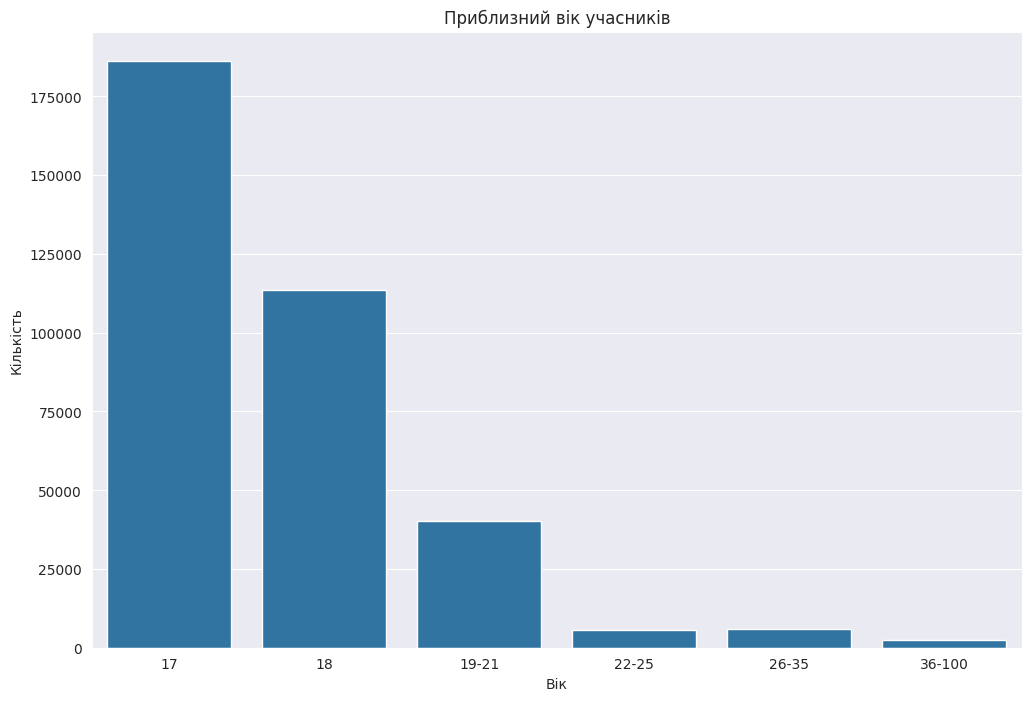

In [15]:
age_counts = age_bins.value_counts(sort=False)
axes = subplots(figsize=(12, 8))[1]
x = age_counts.index.map(make_age_label)
y = age_counts.values
barplot(x=x, y=y, ax=axes, color=default_color)
axes.set_xlabel('Вік')
axes.set_ylabel('Кількість')
axes.set_title('Приблизний вік учасників');

In [16]:
sex_palette = {'чоловіча': '#1f77b4', 'жіноча': '#ff7f0e'}

Можна помітити, що серед екзаменованих майже однакова кількість жінок та чоловіків.

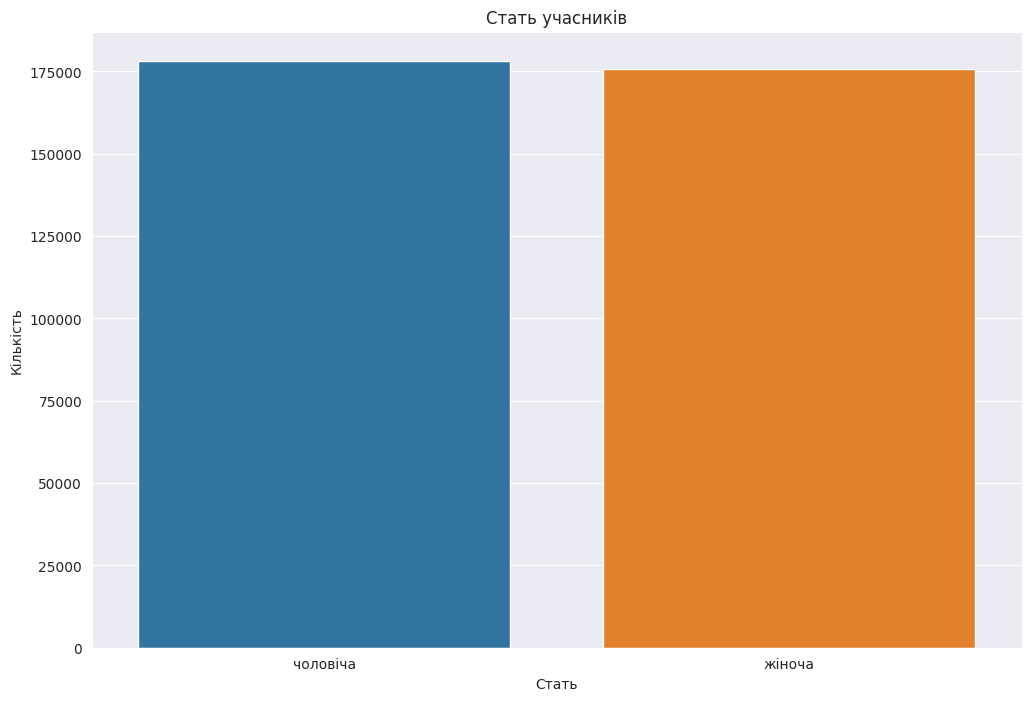

In [17]:
sex_counts = participants['SEXTYPENAME'].value_counts()
axes = subplots(figsize=(12, 8))[1]
barplot(x=sex_counts.index, y=sex_counts, ax=axes, palette=sex_palette)
axes.set_xlabel('Стать')
axes.set_ylabel('Кількість')
axes.set_title('Стать учасників');

Нижче спостерігаємо цікаву картину: майже на 10000 жінок у віці 17 років більше подається на ЗНО. У той же час,
на 10000 і 3000 хлопців більше у віці 18 і 19-21 року відповідно складають ЗНО.

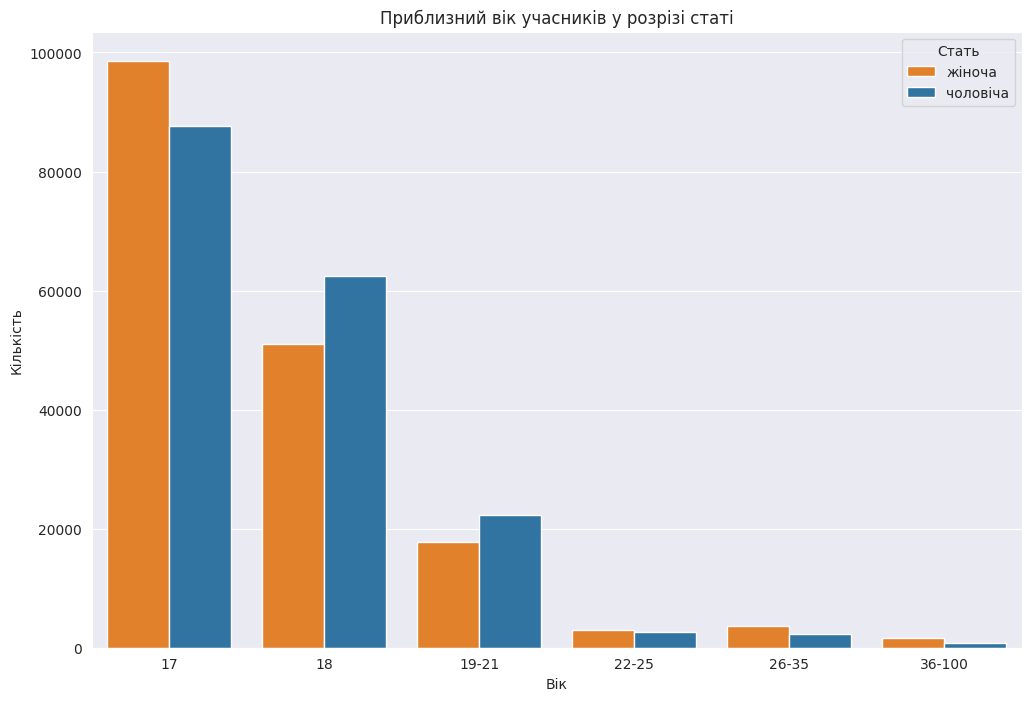

In [18]:
age_sex_counts = (
    concat([participants['SEXTYPENAME'], age_bins], axis=1)
    .groupby(['Age', 'SEXTYPENAME'])
    .size()
)
axes = subplots(figsize=(12, 8))[1]
x = age_sex_counts.index.get_level_values(0).map(make_age_label)
y = age_sex_counts.values
hue = age_sex_counts.index.get_level_values(1).rename('Стать')
barplot(x=x, y=y, hue=hue, ax=axes, palette=sex_palette)
axes.set_xlabel('Вік')
axes.set_ylabel('Кількість')
axes.set_title('Приблизний вік учасників у розрізі статі');

З-поміж найпоширеніших регіонів учасників у топ-5 входять області з містами-мільйонниками: Київ, Дніпропетровська,
Львівська, Одеська, Харківська.

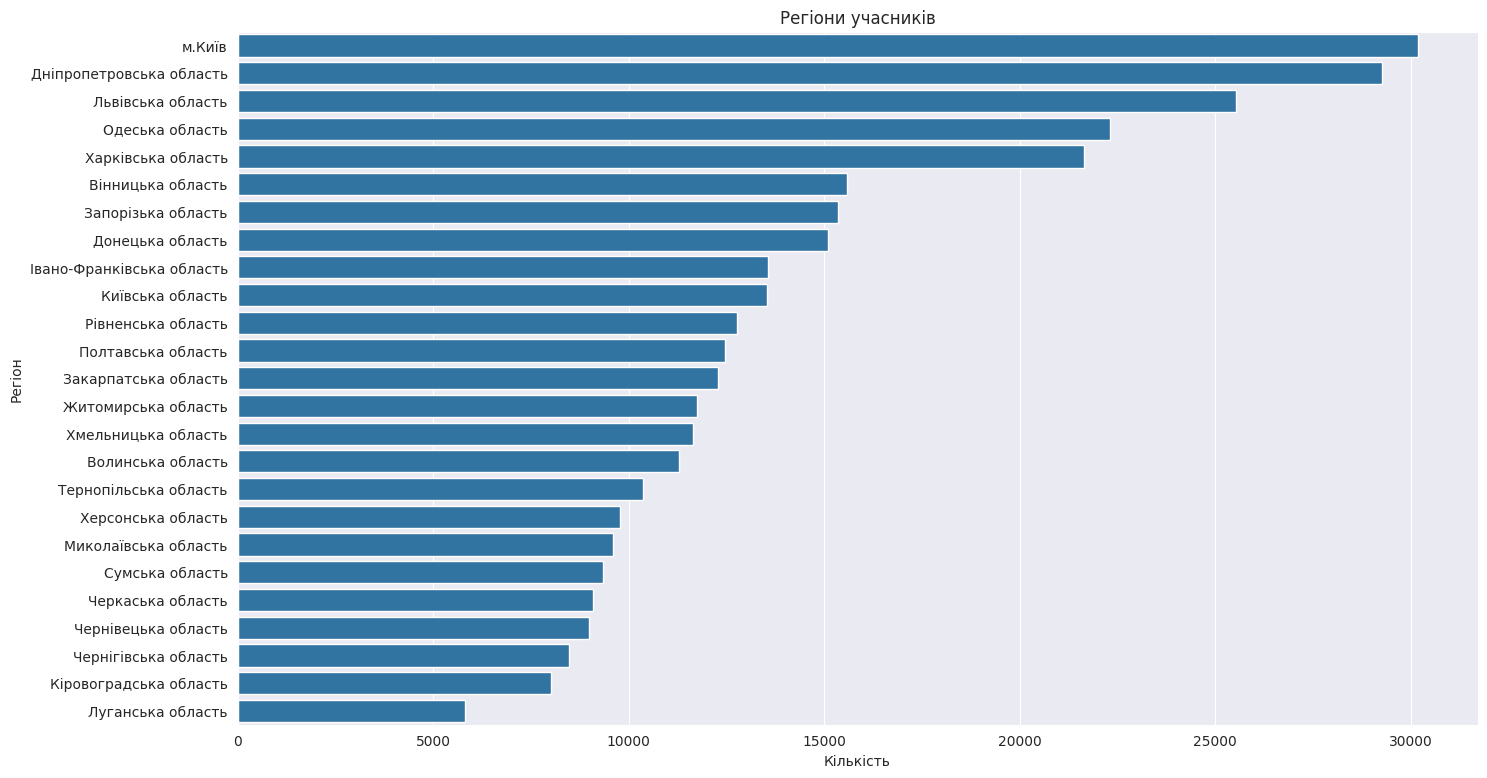

In [19]:
region_counts = participants['REGNAME'].value_counts()
axes = subplots(figsize=(16, 9))[1]
barplot(x=region_counts, y=region_counts.index, ax=axes, color=default_color)
axes.set_xlabel('Кількість')
axes.set_ylabel('Регіон')
axes.set_title('Регіони учасників');

У кожному з регіонів майже однакова кількість чоловіків та жінок, з невеликими перекошеннями на користь з однієї зі
статей.

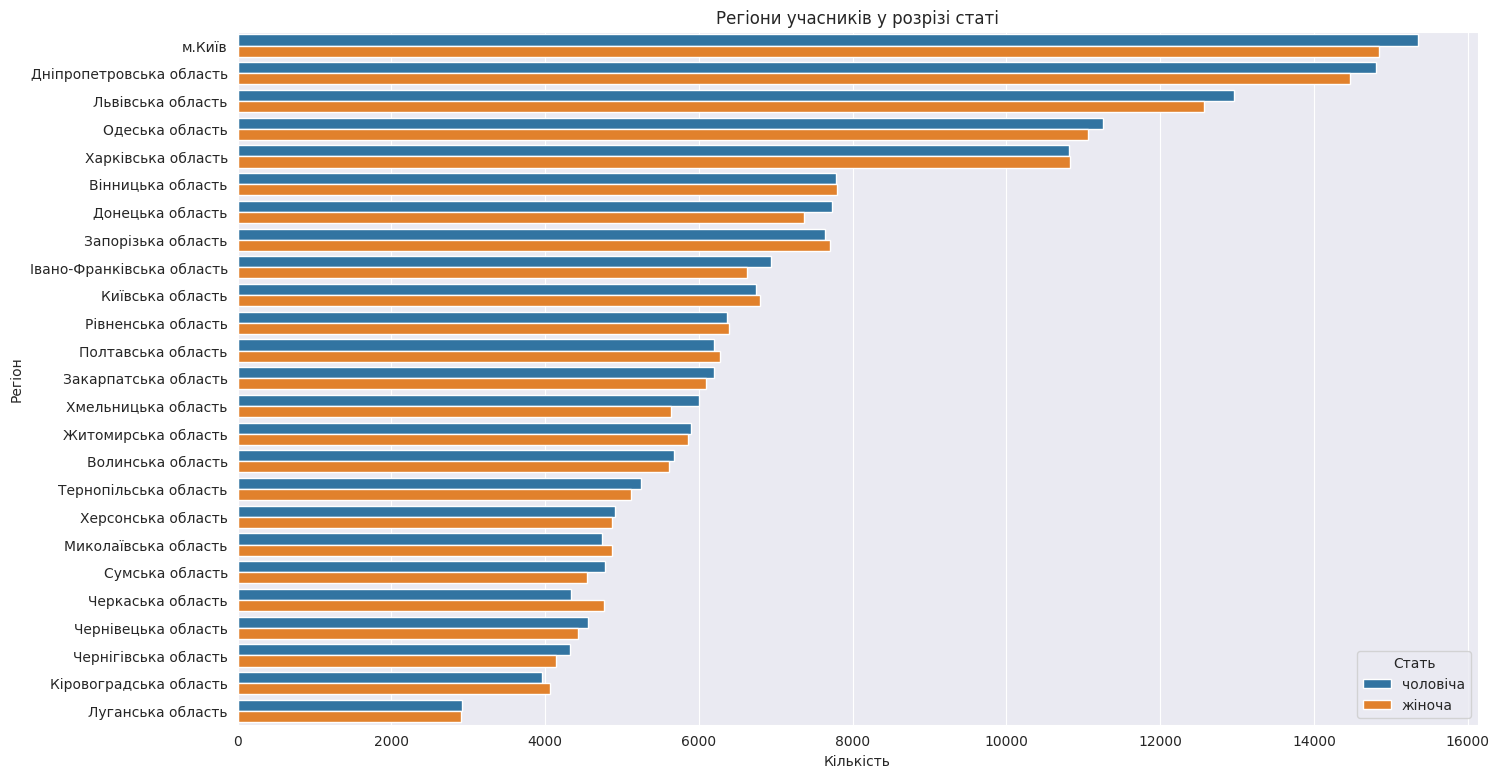

In [20]:
region_sex_counts = participants.groupby(['REGNAME', 'SEXTYPENAME']).size().sort_values(ascending=False)
axes = subplots(figsize=(16, 9))[1]
x = region_sex_counts.values
y = region_sex_counts.index.get_level_values(0)
hue = region_sex_counts.index.get_level_values(1).rename('Стать')
barplot(x=x, y=y, hue=hue, ax=axes, palette=sex_palette)
axes.set_xlabel('Кількість')
axes.set_ylabel('Регіон')
axes.set_title('Регіони учасників у розрізі статі');

In [21]:
def break_caption(caption, n_tokens=3):
    tokens = caption.split()
    output = ' '.join(tokens[:n_tokens])
    for i in range(n_tokens, len(tokens), n_tokens):
        output += '\n' + ' '.join(tokens[i:i + n_tokens])
    return output

Більше половини всіх учасників — випускники закладів середньої освіти у 2019 році. Але також є близько 33 іноземців.

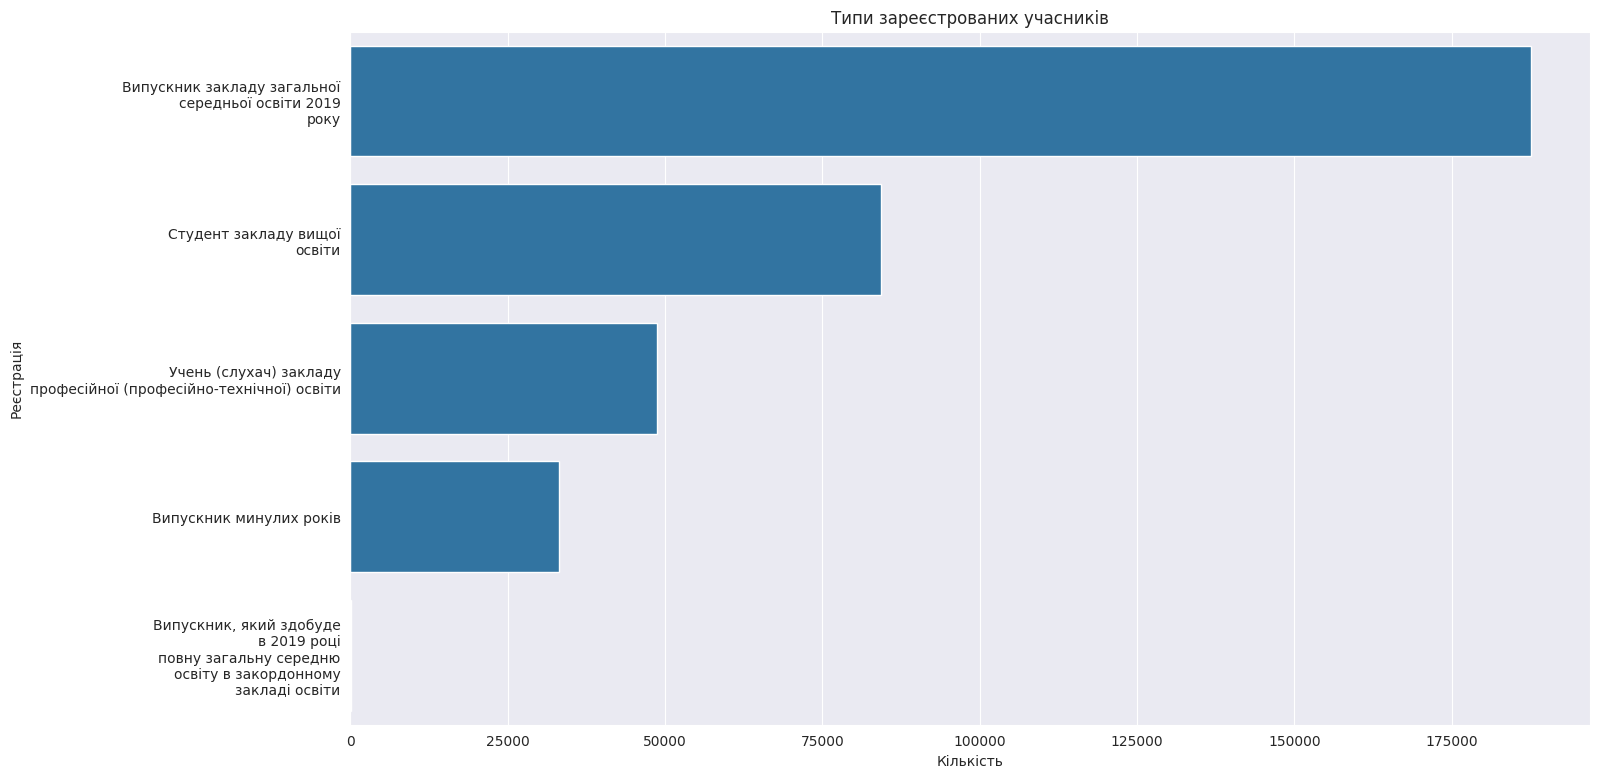

In [22]:
registration_counts = participants['REGTYPENAME'].value_counts()
axes = subplots(figsize=(16, 9))[1]
x = registration_counts.values
y = registration_counts.index.map(break_caption)
barplot(x=x, y=y, ax=axes, color=default_color)
axes.set_xlabel('Кількість')
axes.set_ylabel('Реєстрація')
axes.set_title('Типи зареєстрованих учасників');

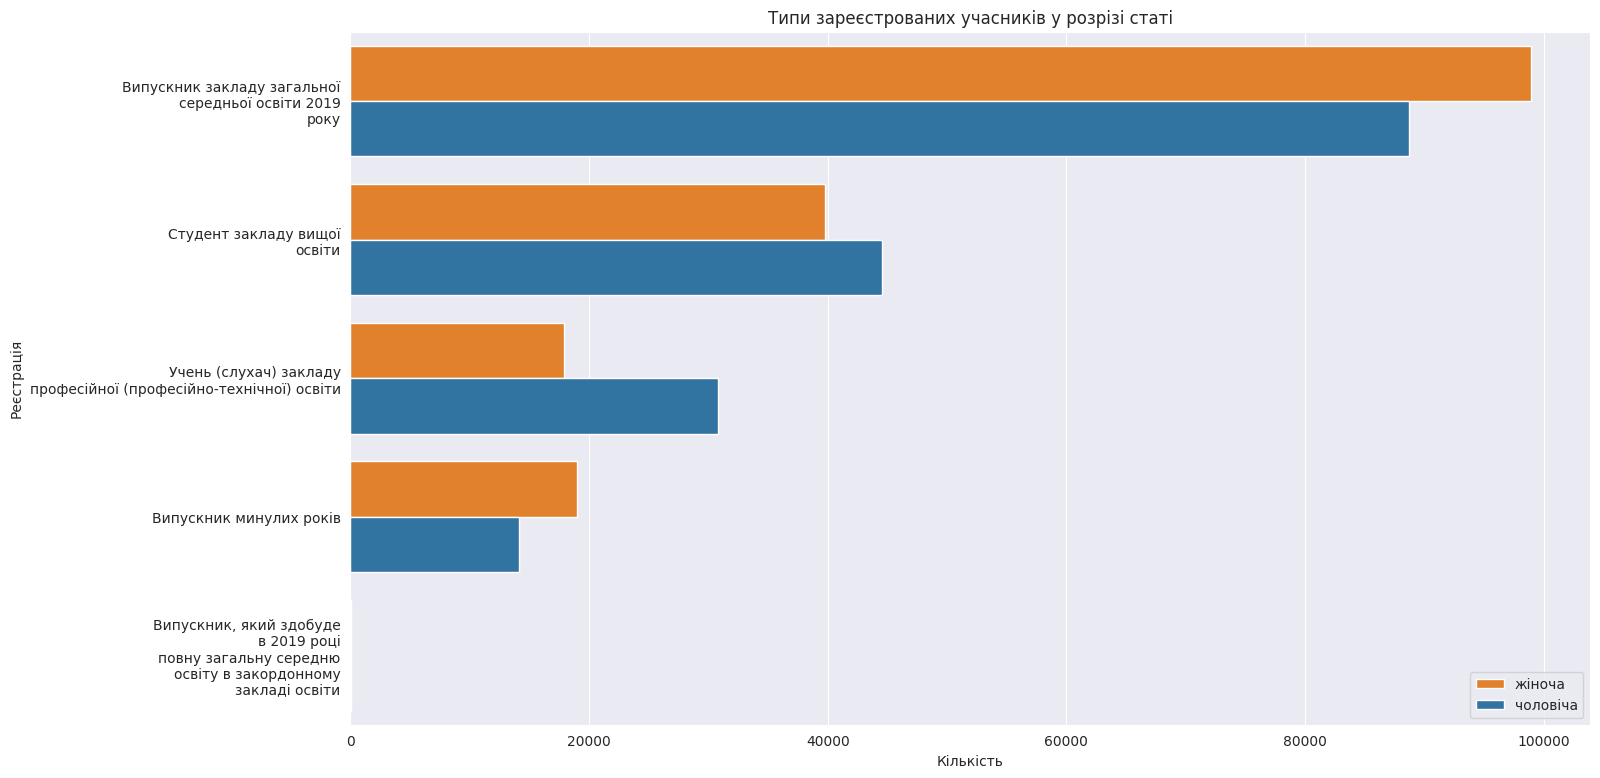

In [23]:
registration_sex_counts = (
    participants
    .groupby(['REGTYPENAME', 'SEXTYPENAME'])
    .size()
    .sort_values(ascending=False)
)
axes = subplots(figsize=(16, 9))[1]
x = registration_sex_counts.values
y = registration_sex_counts.index.get_level_values(0).map(break_caption)
hue = registration_sex_counts.index.get_level_values(1).rename('Стать')
barplot(x=x, y=y, hue=hue, ax=axes, palette=sex_palette)
axes.set_xlabel('Кількість')
axes.set_ylabel('Реєстрація')
axes.set_title('Типи зареєстрованих учасників у розрізі статі')
axes.legend(loc='lower right');

Близько 80% всіх екзаменованих — вихідці з міст.

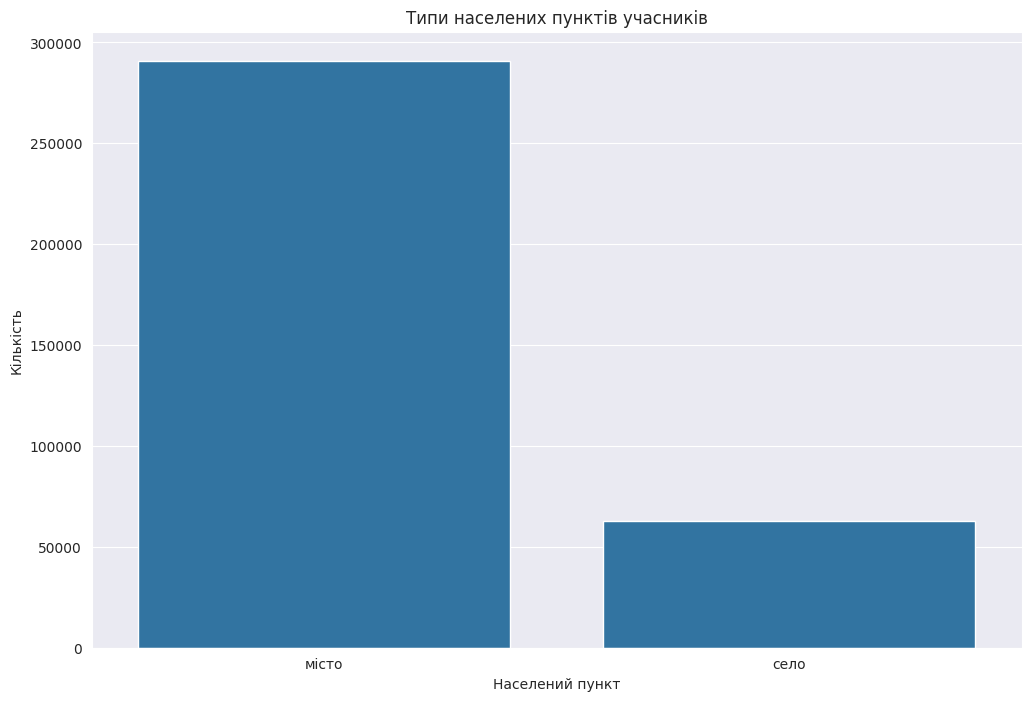

In [24]:
territory_counts = participants['TerTypeName'].value_counts()
axes = subplots(figsize=(12, 8))[1]
barplot(x=territory_counts.index, y=territory_counts.values, ax=axes, color=default_color)
axes.set_xlabel('Населений пункт')
axes.set_ylabel('Кількість')
axes.set_title('Типи населених пунктів учасників');

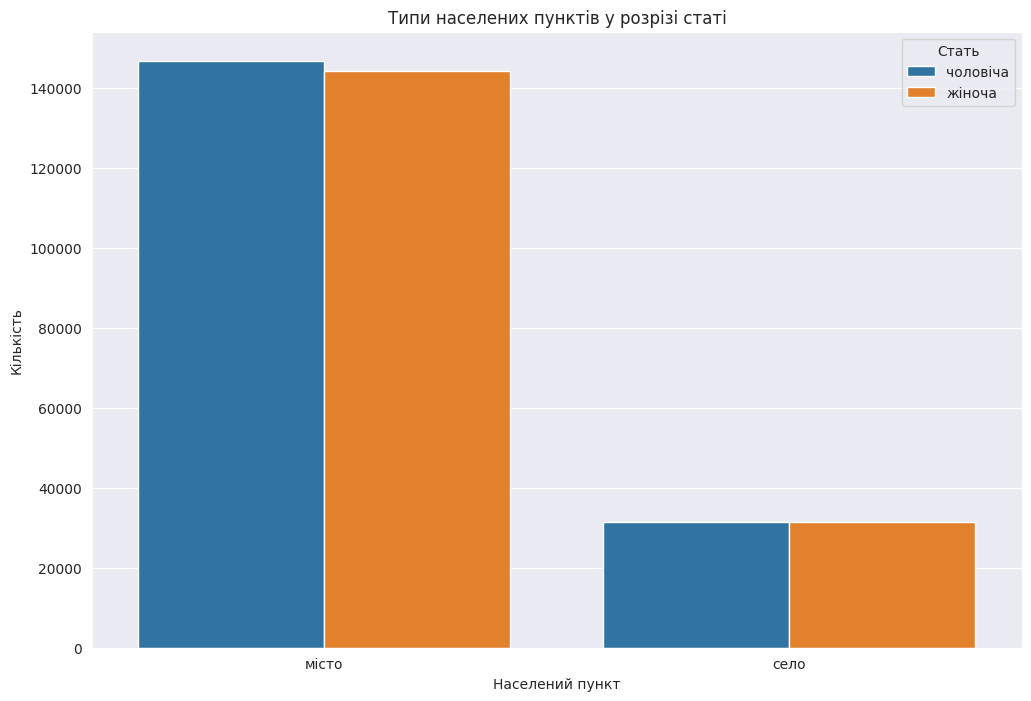

In [25]:
registration_sex_counts = (
    participants
    .groupby(['TerTypeName', 'SEXTYPENAME'])
    .size()
    .sort_values(ascending=False)
)
axes = subplots(figsize=(12, 8))[1]
x = registration_sex_counts.index.get_level_values(0)
y = registration_sex_counts.values
hue = registration_sex_counts.index.get_level_values(1).rename('Стать')
barplot(x=x, y=y, hue=hue, ax=axes, palette=sex_palette)
axes.set_xlabel('Населений пункт')
axes.set_ylabel('Кількість')
axes.set_title('Типи населених пунктів у розрізі статі');

In [26]:
missing_label = 'Не вказано'
missing_color = '#7f7f7f'

Освітні профілі учнів включають як спеціалізації за школами, так і загальні форми для студентів ВНЗ, коледжів і
закладів професійної освіти.

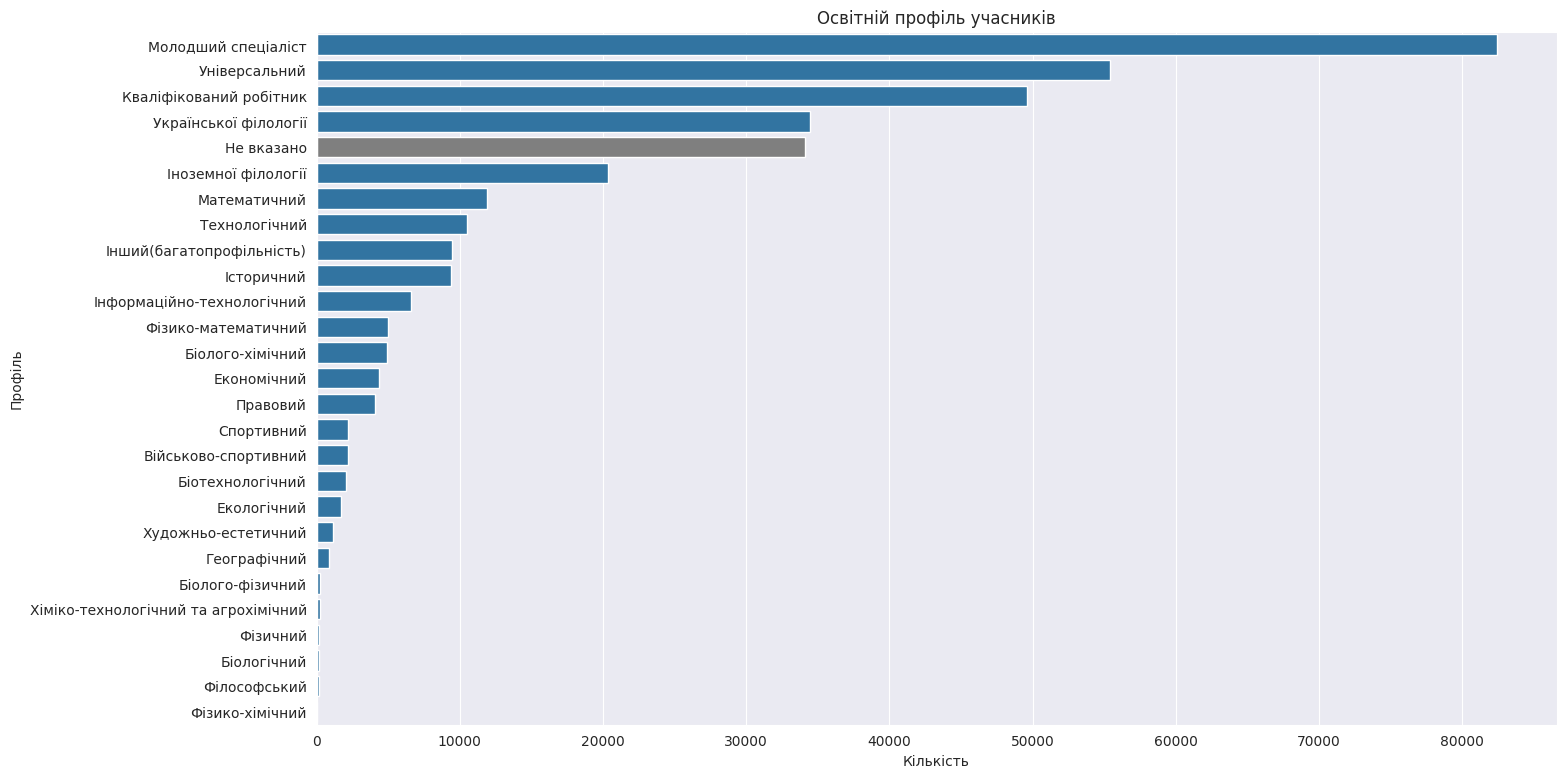

In [27]:
profile_counts = participants['ClassProfileNAME'].replace('', missing_label).value_counts()
axes = subplots(figsize=(16, 9))[1]
palette = where(profile_counts.index == missing_label, missing_color, default_color)
barplot(x=profile_counts.values, y=profile_counts.index, ax=axes, palette=palette)
axes.set_xlabel('Кількість')
axes.set_ylabel('Профіль')
axes.set_title('Освітній профіль учасників');

У переважної більшості — понад 300000 учнів — мовою навчання є українська. Але також присутні російська, угорська,
румунська й молдавська.

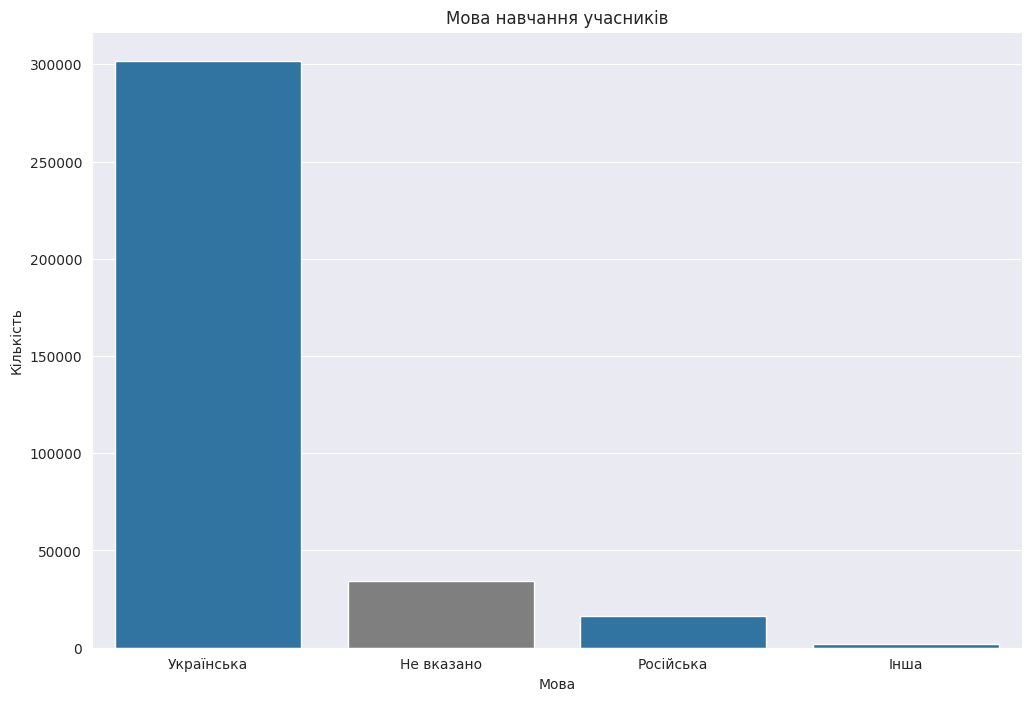

In [28]:
desired_langs = ['українська', '', 'російська']
lang_counts = (
    participants
    ['ClassLangName']
    .where(participants['ClassLangName'].isin(desired_langs), 'інша')
    .str
    .capitalize()
    .replace('', missing_label)
    .value_counts()
)
axes = subplots(figsize=(12, 8))[1]
palette = where(lang_counts.index == missing_label, missing_color, default_color)
barplot(x=lang_counts.index, y=lang_counts.values, ax=axes, palette=palette)
axes.set_xlabel('Мова')
axes.set_ylabel('Кількість')
axes.set_title('Мова навчання учасників');

## Дані навчальних закладів

Якщо відрахувати людей без вказаного закладу освіти, то отримаємо число шкіл і коледжів, чиї випускники взяли участь у
ЗНО.

In [29]:
participants['EONAME'].nunique() - 1

10866

In [30]:
school_counts = participants['EONAME'].value_counts().drop('')

За кількістю абітурієнтів перемагають коледжі різних напрямків з усіх куточків країни.

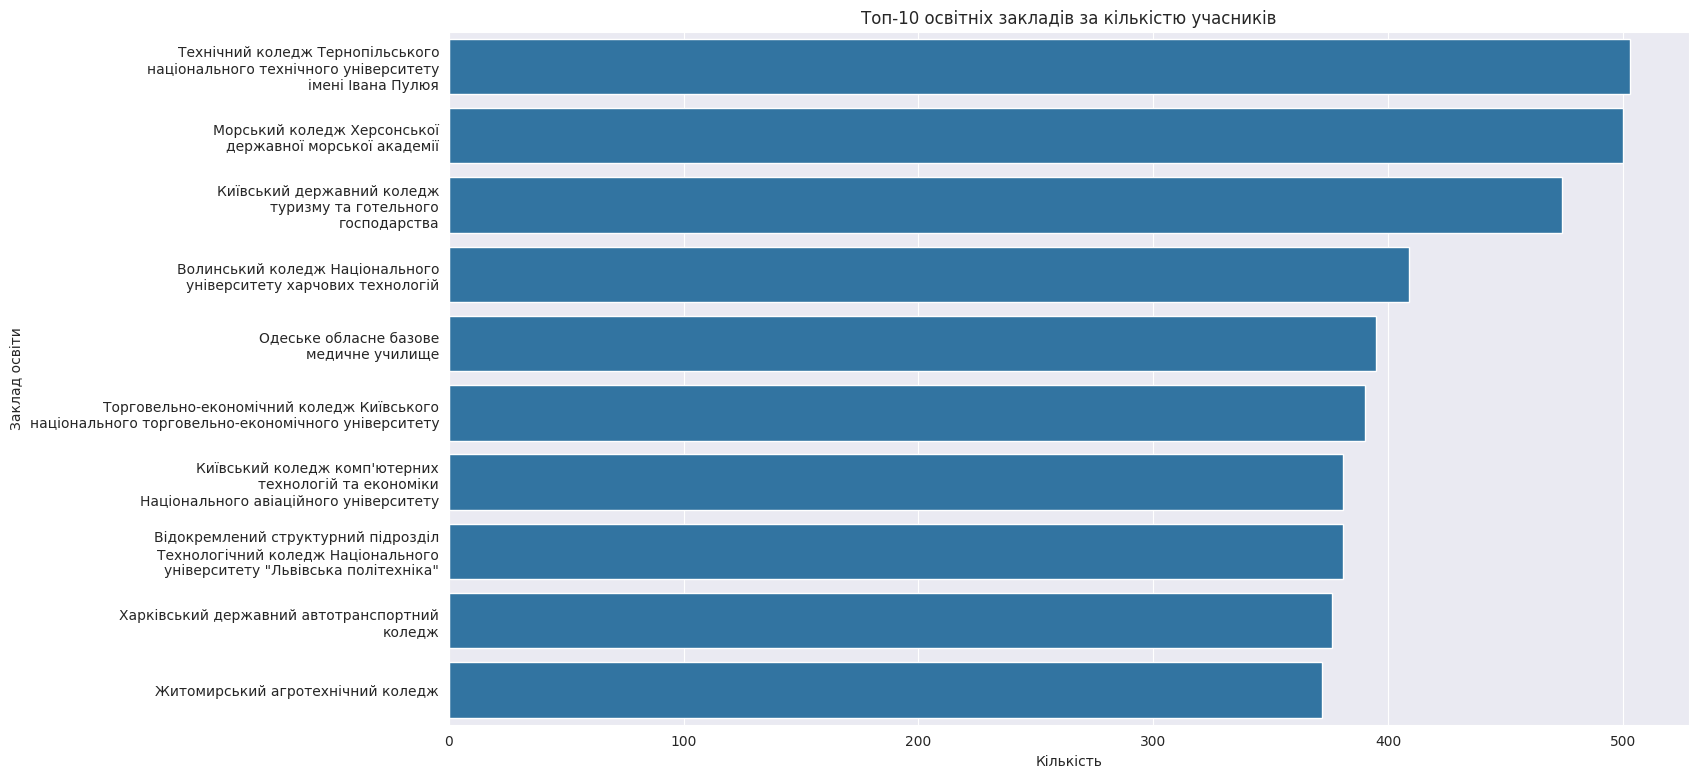

In [31]:
n_schools = 10
top_school_counts = school_counts.nlargest(n_schools)
axes = subplots(figsize=(16, 9))[1]
x = top_school_counts.values
y = top_school_counts.index.map(break_caption)
barplot(x=x, y=y, ax=axes, color=default_color)
axes.set_xlabel('Кількість')
axes.set_ylabel('Заклад освіти')
axes.set_title(f'Топ-{n_schools} освітніх закладів за кількістю учасників');

На гістограмі нижче можна побачити, що кількість абітурієнтів від закладу в середньому складає 1-20 осіб.

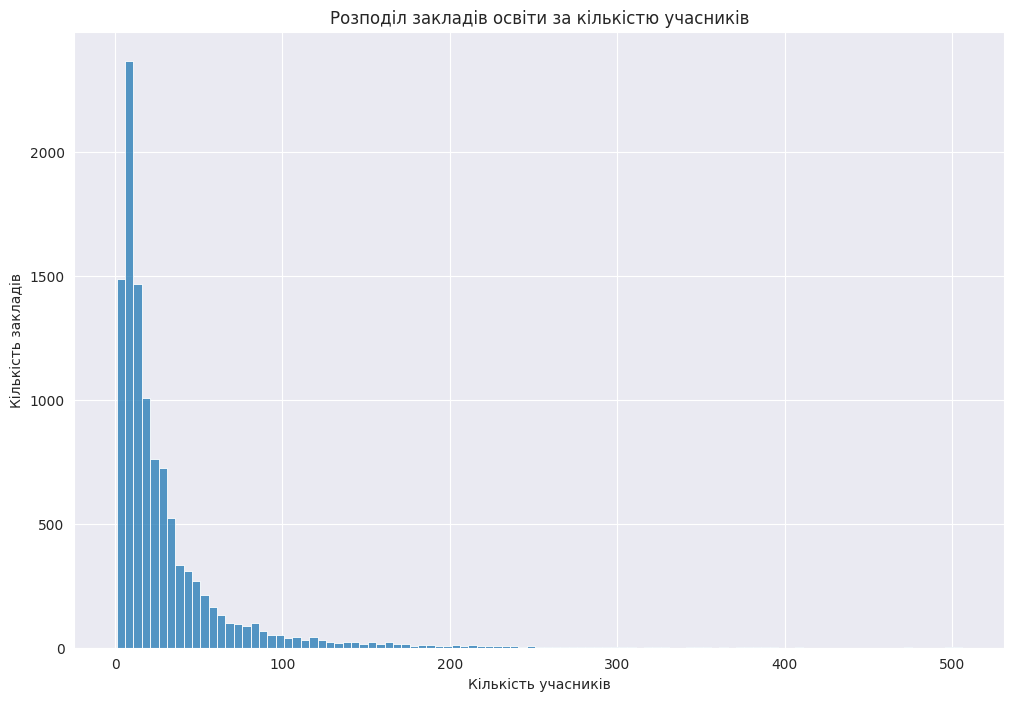

In [34]:
axes = subplots(figsize=(12, 8))[1]
histplot(x=school_counts.values, ax=axes, color=default_color, binwidth=5)
axes.set_xlabel('Кількість учасників')
axes.set_ylabel('Кількість закладів')
axes.set_title('Розподіл закладів освіти за кількістю учасників');

## Дані предметів

Вхідна таблиця сформована неоптимально, тому для простіших фільтрацій і агрегацій її слід привести до вигляду, де кожен
рядок відображає дані про один іспит однієї людини.

In [35]:
subjects = ['Ukr', 'hist', 'math', 'phys', 'chem', 'bio', 'geo', 'eng', 'fra', 'deu', 'spa']

In [36]:
outid_column = 'OUTID'
mandatory_columns = [
    'Test',
    'TestStatus',
    'Ball100',
    'Ball12',
    'Ball',
    'PTName',
    'PTRegName',
    'PTAreaName',
    'PTTerName'
]
scale_column = 'AdaptScale'
dpa_column = 'DPALevel'

In [37]:
partitions = []
for subject in subjects:
    result_columns = [outid_column] + [subject + c for c in mandatory_columns]
    partition = ife[result_columns].copy()
    subject_scale_column = subject + scale_column
    if subject_scale_column in ife.columns:
        partition[subject_scale_column] = ife[subject_scale_column]
    else:
        partition[subject_scale_column] = 0
    subject_dpa_column = subject + dpa_column
    if subject_dpa_column in ife.columns:
        partition[subject_dpa_column] = ife[subject_dpa_column]
    else:
        partition[subject_dpa_column] = ''
    partition.columns = partition.columns.str.lstrip(subject)
    partition.dropna(subset=mandatory_columns[0], inplace=True)
    partitions.append(partition)
results = concat(partitions, ignore_index=True)

In [38]:
results.info(verbose=True, show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041699 entries, 0 to 1041698
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   OUTID       1041699 non-null  object 
 1   Test        1041699 non-null  object 
 2   TestStatus  1041699 non-null  object 
 3   Ball100     996168 non-null   object 
 4   Ball12      801934 non-null   float64
 5   Ball        996168 non-null   float64
 6   PTName      1041699 non-null  object 
 7   PTRegName   1041699 non-null  object 
 8   PTAreaName  1041699 non-null  object 
 9   PTTerName   1041699 non-null  object 
 10  AdaptScale  1041699 non-null  int64  
 11  DPALevel    999967 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 95.4+ MB


In [39]:
results.head(10)

,OUTID,Test,TestStatus,Ball100,Ball12,Ball,PTName,PTRegName,PTAreaName,PTTerName,AdaptScale,DPALevel
0,07ad4c55-70ef-442d-bb7f-34c95c0e6ee4,Українська мова і література,Зараховано,"100,0",4.0,23.0,"Комунальний заклад ""Василівська гімназія ""Сузі...",Запорізька область,Василівський район,м.Василівка,0,
1,8626c448-3a7d-434f-b01a-c2530ccf3a4f,Українська мова і література,Не з’явився,NaN,NaN,NaN,Заклад загальної середньо освіти І-ІІІ ступені...,Донецька область,м.Торецьк,м.Торецьк,0,
2,9709b00b-144c-4487-b7bc-66c0b353b324,Українська мова і література,Зараховано,"166,0",10.0,68.0,Тернопільська загальноосвітня школа І-ІІІ ступ...,Тернопільська область,м.Тернопіль,м.Тернопіль,0,
3,5617254e-aee4-4fa6-81cc-f0159cc972bc,Українська мова і література,Зараховано,"127,0",6.0,38.0,Вараська загальноосвітня школа І-ІІІ ступенів ...,Рівненська область,м.Вараш,м.Вараш,0,
4,2e8b9de3-8806-415a-bad1-be822ef8a042,Українська мова і література,Зараховано,"171,0",9.0,72.0,Новоукраїнська загальноосвітня школа І-ІІІ сту...,Кіровоградська область,Новоукраїнський район,м.Новоукраїнка,0,
5,68a81d38-42e6-40fd-a145-9fb6ed2565ea,Українська мова і література,Не подолав поріг,"0,0",2.0,6.0,Свалявська загальноосвітня школа І-ІІІ ступені...,Закарпатська область,Свалявський район,м.Свалява,0,
6,d29508d2-7fc3-4462-b5e8-e82e7ac3d3b5,Українська мова і література,Не подолав поріг,"0,0",2.0,17.0,Спеціалізована школа №7 імені М.Т.Рильського м...,м.Київ,м.Київ. Солом'янський район міста,Солом'янський район міста,0,
7,eb149a7d-984e-4295-807c-12538b83b2d5,Українська мова і література,Зараховано,"157,0",8.0,60.0,Волноваська загальноосвітня школа I-III ступен...,Донецька область,Волноваський район,м.Волноваха,0,
8,da969cfc-c91c-4a52-885f-21117e6e07f0,Українська мова і література,Зараховано,"100,0",4.0,23.0,Середня загальносвітня школа І-ІІІ ступенів № 62,м.Київ,м.Київ. Дарницький район міста,Дарницький район міста,0,
9,46a12d3d-00d5-4d22-aea1-c2a2adf3d1d4,Українська мова і література,Зараховано,"189,0",11.0,90.0,Дунаєвецька загальноосвітня школа I-III ступен...,Хмельницька область,Дунаєвецький район,м.Дунаївці,0,


Порожні значення заповнюємо нульовими, аби позбавити себе несподіваної поведінки з `nan`.

In [40]:
results['Ball100'] = results['Ball100'].fillna('0').str.replace(',', '.').astype(float)

In [41]:
results['Ball12'] = results['Ball12'].fillna(0)

In [42]:
results['Ball'] = results['Ball'].fillna(0)

In [43]:
results['DPALevel'] = results['DPALevel'].fillna('')

In [44]:
results.info(verbose=True, show_counts=True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041699 entries, 0 to 1041698
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   OUTID       1041699 non-null  object 
 1   Test        1041699 non-null  object 
 2   TestStatus  1041699 non-null  object 
 3   Ball100     1041699 non-null  float64
 4   Ball12      1041699 non-null  float64
 5   Ball        1041699 non-null  float64
 6   PTName      1041699 non-null  object 
 7   PTRegName   1041699 non-null  object 
 8   PTAreaName  1041699 non-null  object 
 9   PTTerName   1041699 non-null  object 
 10  AdaptScale  1041699 non-null  int64  
 11  DPALevel    1041699 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 95.4+ MB


Найпоширеніші іспити — з української мови й літератури, історії України та математики, як обов'язкові предмети.

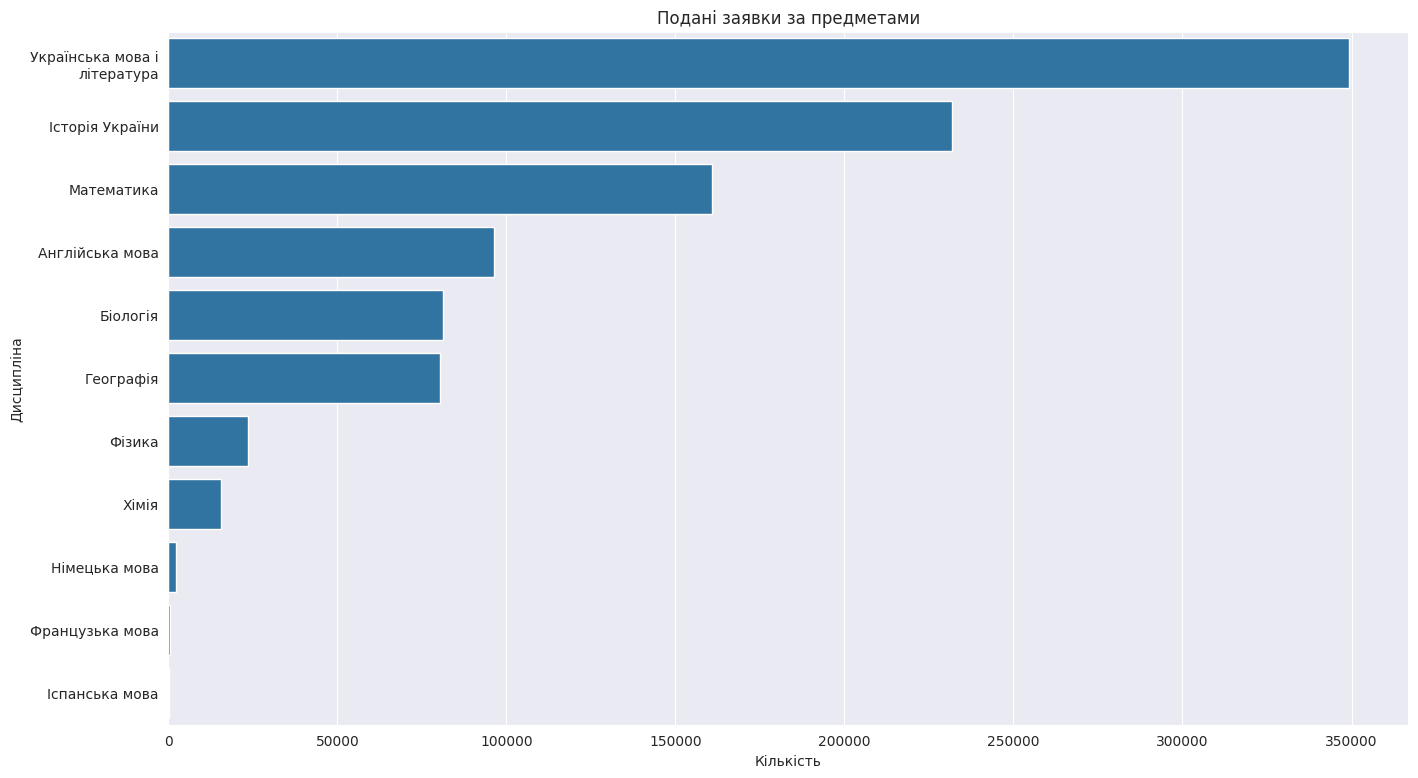

In [45]:
test_counts = results['Test'].value_counts()
axes = subplots(figsize=(16, 9))[1]
x = test_counts.values
y = test_counts.index.map(break_caption)
barplot(x=x, y=y, ax=axes, color=default_color)
axes.set_xlabel('Кількість')
axes.set_ylabel('Дисципліна')
axes.set_title('Подані заявки за предметами');

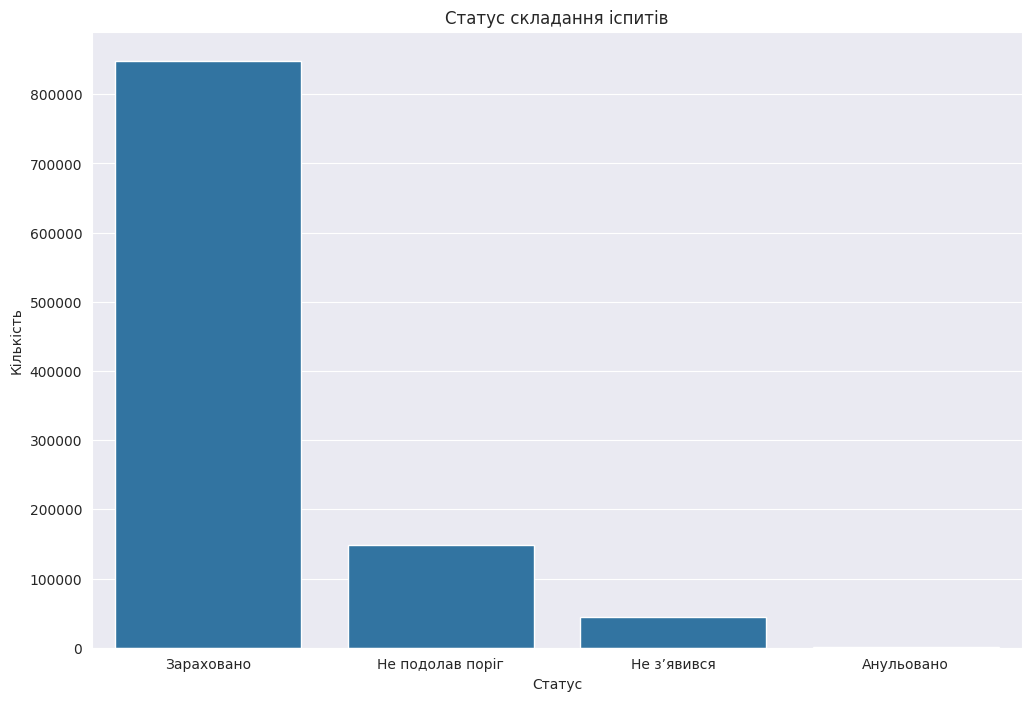

In [46]:
status_counts = results['TestStatus'].value_counts()
axes = subplots(figsize=(12, 8))[1]
x = status_counts.index
y = status_counts.values
barplot(x=x, y=y, ax=axes, color=default_color)
axes.set_xlabel('Статус')
axes.set_ylabel('Кількість')
axes.set_title('Статус складання іспитів');

In [47]:
status_colors = {
    'Зараховано': '#1f77b4',
    'Не подолав поріг': '#ff7f0e',
    'Анульовано': '#d62728',
    'Не з’явився': '#7f7f7f'
}

Не всі подані заявки успішно складаються — у частині випадків учень не приходить на іспит, стає дискваліфікованим чи
не набирає достатньої кількості балів. Однак у біології, географії та англійської мови найвищий відсоток успішно
складених робіт.

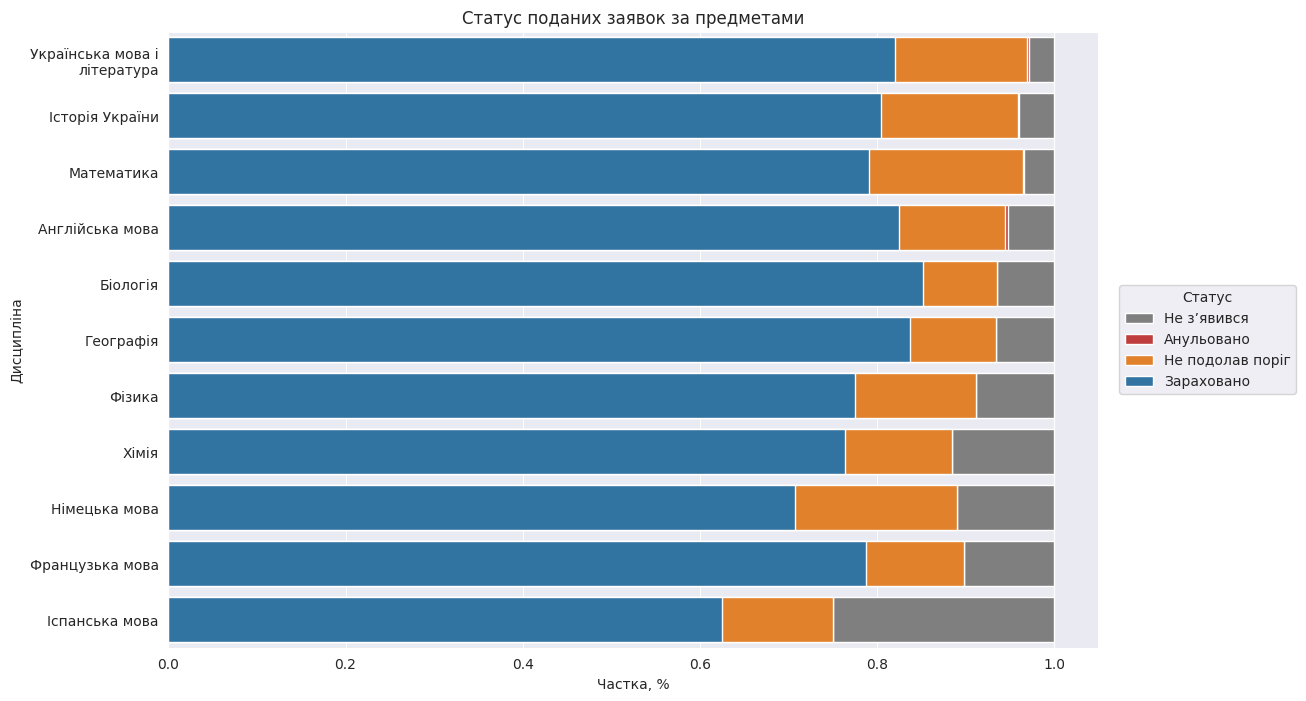

In [48]:
subject_status_shares = (
    results
    .groupby(['Test', 'TestStatus'], as_index=False)
    .size()
    .pivot(index='Test', columns='TestStatus', values='size')
    .fillna(0)
    .sort_values('Зараховано', ascending=False)
)
subject_status_shares = subject_status_shares[list(status_colors.keys())]
subject_status_shares = subject_status_shares.div(subject_status_shares.sum(1), 0).cumsum(1)
axes = subplots(figsize=(12, 8))[1]
for status, color in reversed(status_colors.items()):
    shares = subject_status_shares[status]
    x = shares.values
    y = shares.index.map(break_caption)
    barplot(x=x, y=y, color=color, ax=axes, label=status)
axes.set_xlabel('Частка, %')
axes.set_ylabel('Дисципліна')
axes.set_title('Статус поданих заявок за предметами')
axes.legend(loc='center right', title='Статус', bbox_to_anchor=(1.22, 0.5));

До речі, забавна статистика — більшість предметів складається переважно жінками, окрім двох — математики й фізики, які
обирає більше чоловіків.

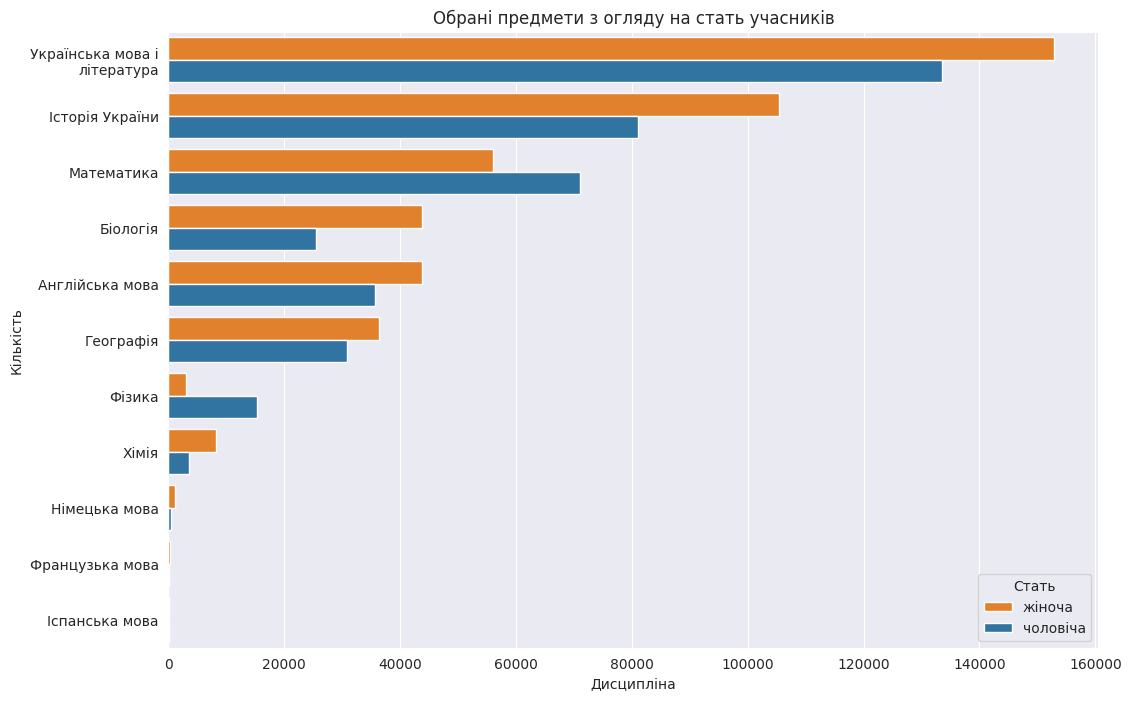

In [49]:
subject_sex_counts = (
    results
    [results['TestStatus'] == 'Зараховано']
    .join(participants['SEXTYPENAME'], 'OUTID')
    .groupby(['Test', 'SEXTYPENAME'])
    .size()
    .sort_values(ascending=False)
)
axes = subplots(figsize=(12, 8))[1]
x = subject_sex_counts.values
y = subject_sex_counts.index.get_level_values(0).map(break_caption)
hue = subject_sex_counts.index.get_level_values(1)
barplot(x=x, y=y, hue=hue, ax=axes, palette=sex_palette)
axes.set_xlabel('Дисципліна')
axes.set_ylabel('Кількість')
axes.set_title('Обрані предмети з огляду на стать учасників')
axes.legend(loc='lower right', title='Стать');

In [50]:
territory_palette = {'місто': '#1f77b4', 'село': '#ff7f0e'}

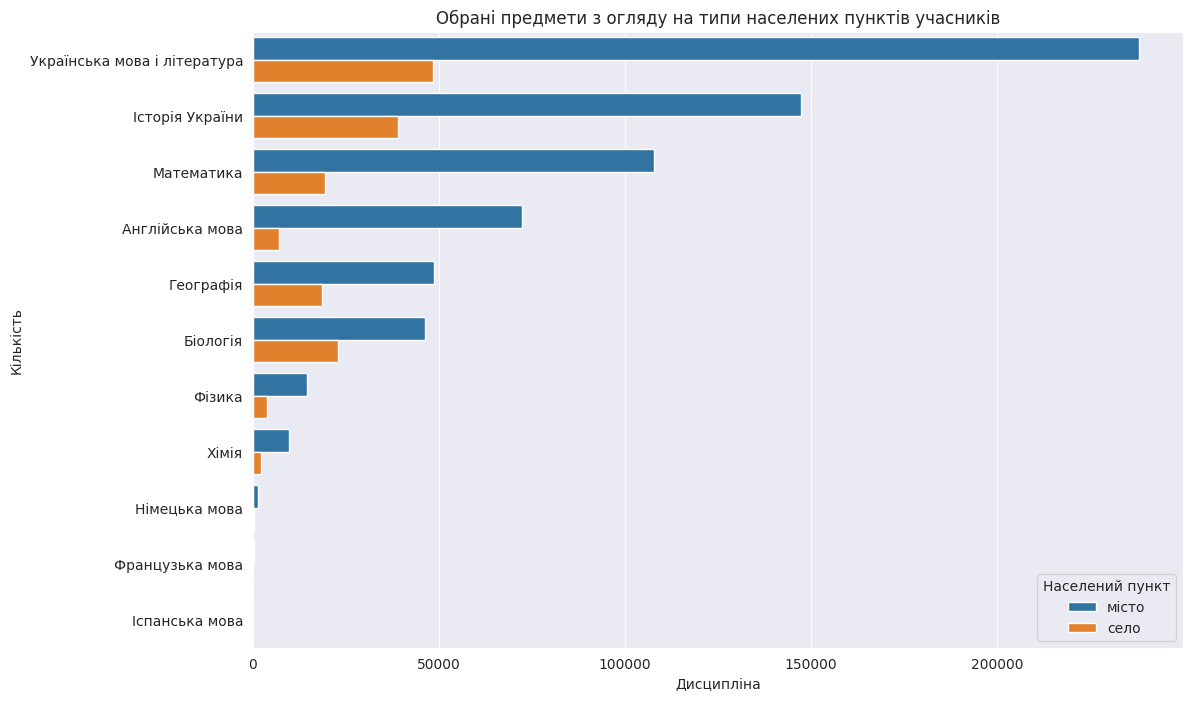

In [51]:
subject_territory_counts = (
    results
    [results['TestStatus'] == 'Зараховано']
    .join(participants['TerTypeName'], 'OUTID')
    .groupby(['Test', 'TerTypeName'])
    .size()
    .sort_values(ascending=False)
)
axes = subplots(figsize=(12, 8))[1]
x = subject_territory_counts.values
y = subject_territory_counts.index.get_level_values(0)
hue = subject_territory_counts.index.get_level_values(1)
barplot(x=x, y=y, hue=hue, ax=axes, palette=territory_palette)
axes.set_xlabel('Дисципліна')
axes.set_ylabel('Кількість')
axes.set_title('Обрані предмети з огляду на типи населених пунктів учасників')
axes.legend(loc='lower right', title='Населений пункт');

З-поміж усіх дисциплін три мають відносно невелику кількість даних, через що мають дещо нерівномірні середні оцінки.
Якщо порахувати середнє арифметичне для учнів з кожного регіону й кожного предмету, то вийде теплова карта нижче. На
ній можна бачити кілька прогалин в результатах іспанської та французької мов — дається взнаки відсутність іспитів у
відповідних областях.

Серед усіх регіонів хочеться виділити два — Львівську область і Київ, котрі мають середні оцінки по всіх предметах вище
чи на рівні з іншими областями. Це можна пояснити великою концентрацією спеціалізованих навчальних закладів у Львові й
Києві, чиї випускники зі знанням справи складають профільні іспити. У той же час, є і аутсайдери по середніх оцінках —
Закарпатська, Херсонська та Чернівецька області.

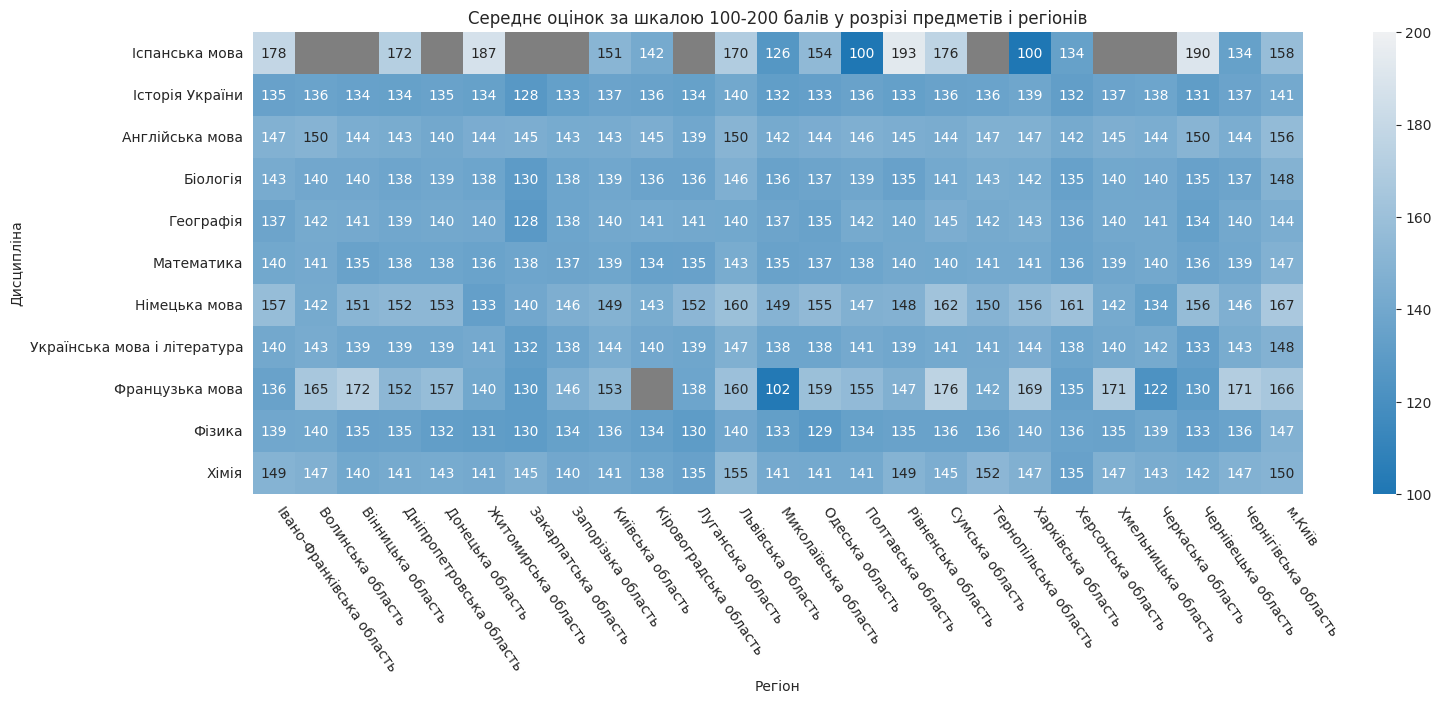

In [52]:
region_test_scores = (
    results
    [results['TestStatus'] == 'Зараховано']
    [['OUTID', 'Test', 'Ball100']]
    .join(participants['REGNAME'], 'OUTID')
    .groupby(['Test', 'REGNAME'], as_index=False)
    ['Ball100']
    .mean()
    .pivot(index='Test', columns='REGNAME', values='Ball100')
)
mask = region_test_scores.isnull()
axes = subplots(figsize=(18, 6))[1]
cmap = color_palette(f'light:{default_color}_r', as_cmap=True)
graph = heatmap(
    region_test_scores,
    vmin=100,
    vmax=200,
    mask=mask,
    ax=axes,
    square=True,
    cmap=cmap,
    annot=True,
    fmt='.0f'
)
graph.set_facecolor(missing_color)
graph.set_xticklabels(graph.get_xticklabels(), rotation=305, horizontalalignment='left')
axes.grid(False)
axes.set_xlabel('Регіон')
axes.set_ylabel('Дисципліна')
axes.set_title('Середнє оцінок за шкалою 100-200 балів у розрізі предметів і регіонів');

## Гіпотези про оцінки учасників

А тепер розберемо кілька припущень про якості та результати учнів. Але перед тим цікаво поглянути на тенденції оцінок
за дисциплінами. Тут варто відзначити чотири іноземні мови — англійську, німецьку, французьку й іспанську. Останні три
користуються на два порядки меншою популярністю, ніж перша. Разом з тим, їхні квартилі знаходяться помітно вище за
решту предметів. Це можна було би пов'язати з мотивацією вивчати іноземні мови — ті, хто їх складають, краще за колег
вмотивовані на вищий результат.

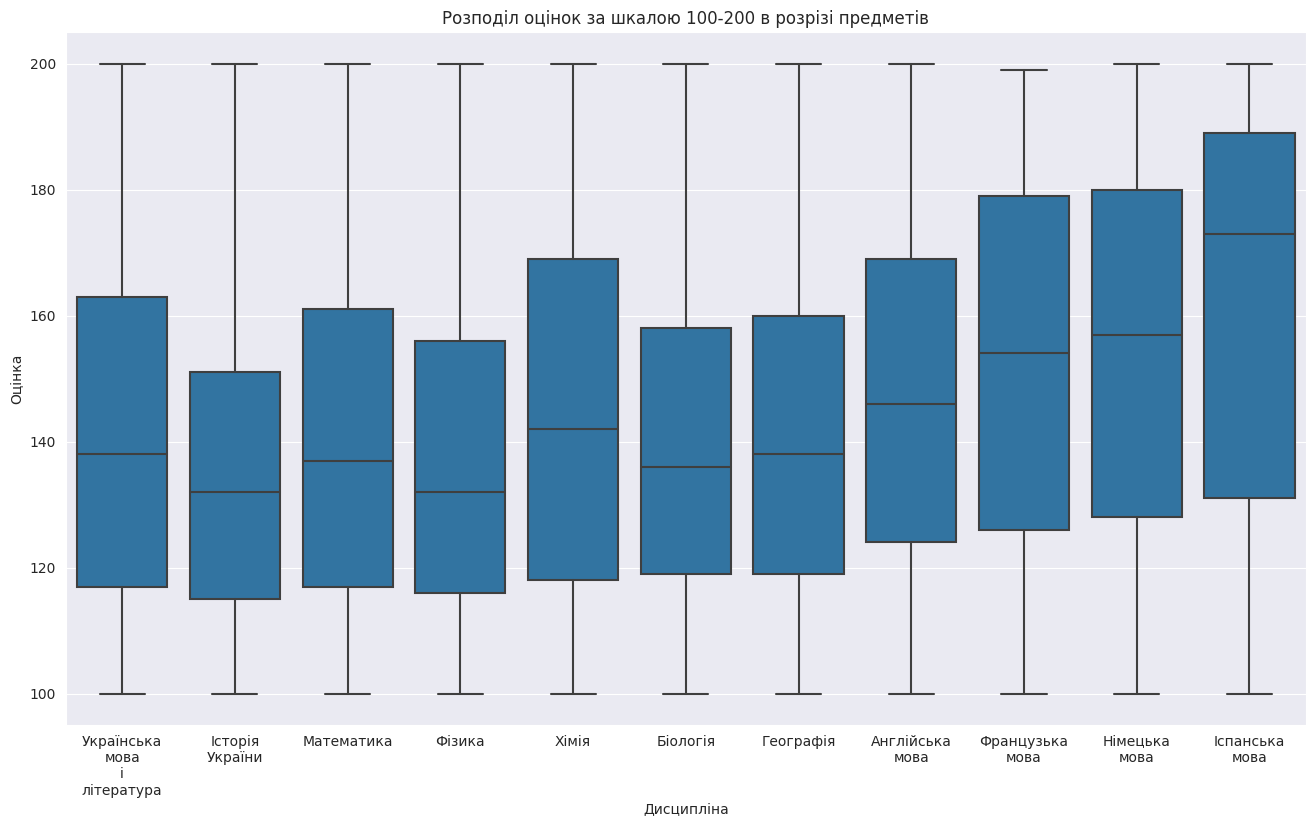

In [53]:
axes = subplots(figsize=(16, 9))[1]
passed_results = results[results['TestStatus'] == 'Зараховано']
x = passed_results['Test'].map(lambda t: break_caption(t, 1))
y = passed_results['Ball100']
boxplot(x=x, y=y, ax=axes, color=default_color)
axes.set_xlabel('Дисципліна')
axes.set_ylabel('Оцінка')
axes.set_title('Розподіл оцінок за шкалою 100-200 в розрізі предметів');

А тепер перевіримо стереотипне твердження, чи складають жінки ЗНО гірше за чоловіків. Для цього згрупуємо дані за
статтю й предметами, після чого загрегуємо й побудуємо "ящики з вусами". Як бачимо, жінки мають рівні чи вищі покази
всюди, окрім хімії.

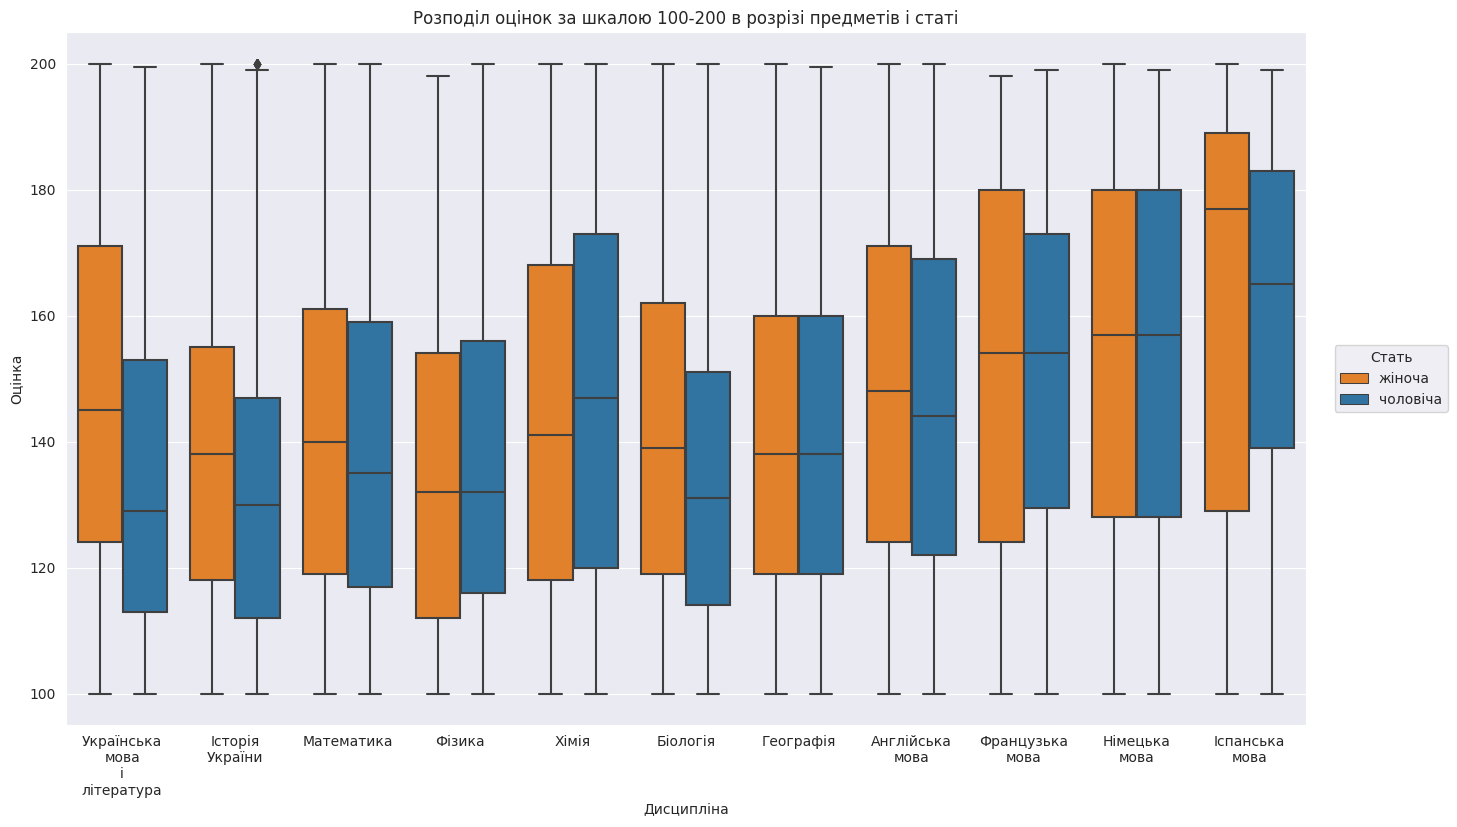

In [54]:
axes = subplots(figsize=(16, 9))[1]
passed_results = results[results['TestStatus'] == 'Зараховано'].join(participants['SEXTYPENAME'], 'OUTID')
x = passed_results['Test'].map(lambda t: break_caption(t, 1))
y = passed_results['Ball100']
hue = passed_results['SEXTYPENAME']
boxplot(x=x, y=y, ax=axes, hue=hue, palette=sex_palette)
axes.set_xlabel('Дисципліна')
axes.set_ylabel('Оцінка')
axes.set_title('Розподіл оцінок за шкалою 100-200 в розрізі предметів і статі')
axes.legend(loc='center right', title='Стать', bbox_to_anchor=(1.12, 0.5));

А тепер перевіримо кілька гіпотез з допомогою T-статистики Велша. Вони дають відповідь на питання: "Чи є істотна
різниця між середніми оцінками жінок і чоловіків за дисцпипліну X?" — В якості довірчого значення оберемо
$\alpha = 0.05$. Як бачимо, в математиці жінки відрізняються від чоловіків. А, оскільки їхній ящик з вусами має вищі
квартилі, жінки в середньому складають ЗНО з математики краще за чоловіків.

In [55]:
records = []
for subject in tqdm(results['Test'].unique()):
    subject_scores = (
        results
        [(results['TestStatus'] == 'Зараховано') & (results['Test'] == subject)]
        .join(participants['SEXTYPENAME'], 'OUTID')
        [['SEXTYPENAME', 'Ball100']]
    )
    a = subject_scores[subject_scores['SEXTYPENAME'] == 'жіноча']['Ball100']
    b = subject_scores[subject_scores['SEXTYPENAME'] == 'чоловіча']['Ball100']
    output = ttest_ind(a, b, equal_var=False)
    record = (subject, len(a), len(b), output.statistic, output.pvalue)
    records.append(record)
ttest_columns = ['Дисципліна', 'Заявки від жінок', 'Заявки від чоловіків', 'T-статистика', 'p-value']
DataFrame(records, columns=ttest_columns)

  0%|          | 0/11 [00:00<?, ?it/s]

,Дисципліна,Заявки від жінок,Заявки від чоловіків,T-статистика,p-value
0,Українська мова і література,152882,133531,121.852646,0.000000e+00
1,Історія України,105432,81015,59.193546,0.000000e+00
2,Математика,56031,71062,13.941433,3.835892e-44
3,Фізика,2962,15240,-1.812396,6.999698e-02
4,Хімія,8191,3637,-6.049725,1.529206e-09
5,Біологія,43716,25542,34.567289,4.789954e-259
6,Географія,36359,30854,-3.829520,1.285139e-04
7,Англійська мова,43689,35704,11.542855,8.509960e-31
8,Французька мова,341,144,0.118219,9.059763e-01
9,Німецька мова,1101,449,0.316883,7.514139e-01


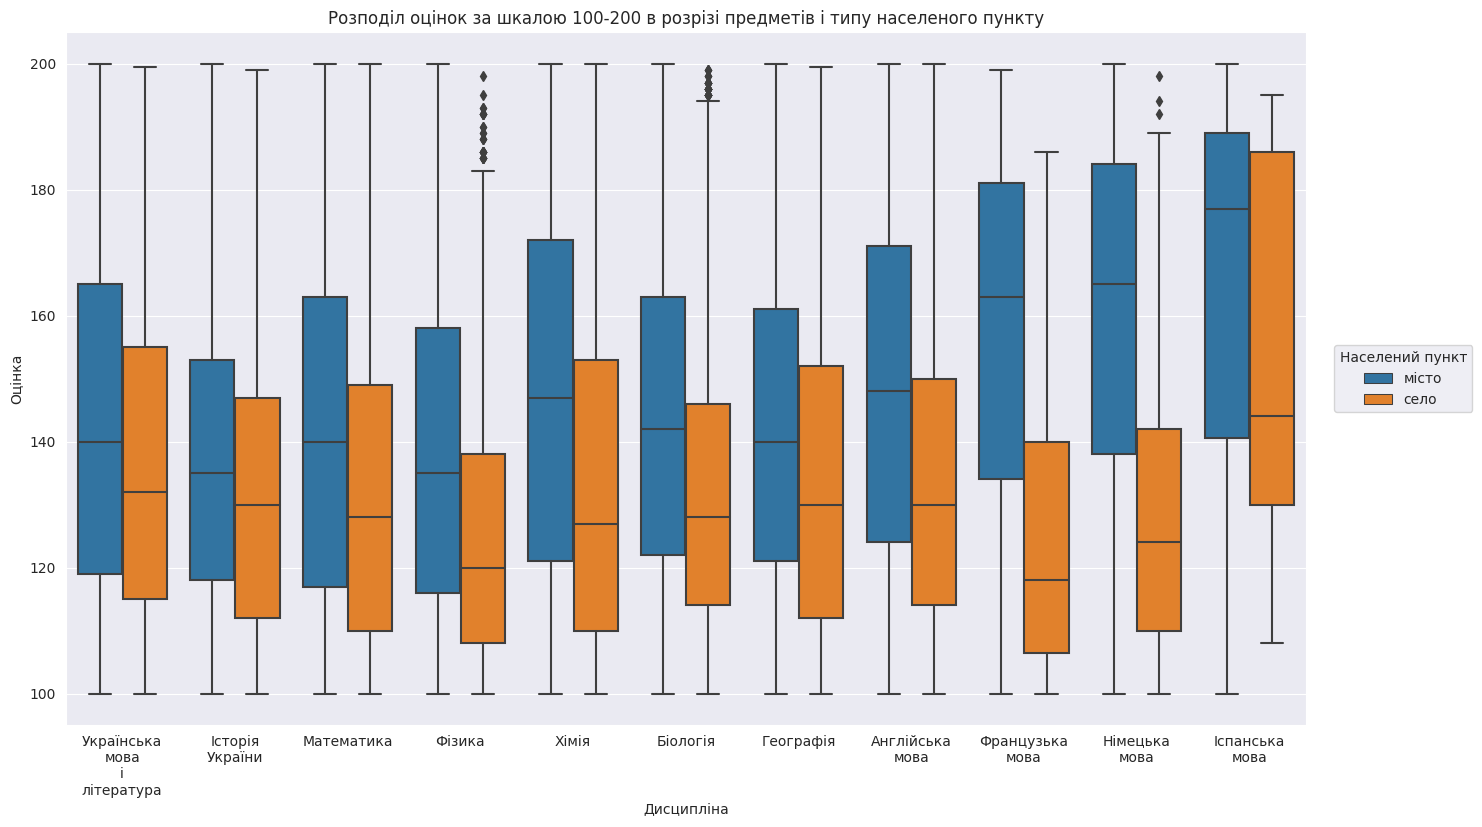

In [56]:
axes = subplots(figsize=(16, 9))[1]
passed_results = results[results['TestStatus'] == 'Зараховано'].join(participants['TerTypeName'], 'OUTID')
x = passed_results['Test'].map(lambda t: break_caption(t, 1))
y = passed_results['Ball100']
hue = passed_results['TerTypeName']
boxplot(x=x, y=y, ax=axes, hue=hue, palette=territory_palette)
axes.set_xlabel('Дисципліна')
axes.set_ylabel('Оцінка')
axes.set_title('Розподіл оцінок за шкалою 100-200 в розрізі предметів і типу населеного пункту')
axes.legend(loc='center right', title='Населений пункт', bbox_to_anchor=(1.14, 0.5));

Ну й наостанок — топ-20 шкіл України за середніми оцінками з математики, фізики й англійської, як найбільш близьких до
комп'ютерних наук. В якості метрики виступає середнє арифметичне балу. Також відсіюються ті школи, в кого на дисципліну
знайшлося менше 5 осіб. 

In [57]:
desired_subjects = ['Математика', 'Фізика', 'Англійська мова']
top_score_columns = ['Заклад освіти', 'Середня оцінка', 'Кількість учасників']
for subject in desired_subjects:
    school_subject_scores = (
        results
        [(results['TestStatus'] == 'Зараховано') & (results['Test'] == subject)]
        .join(participants[participants['EONAME'] != '']['EONAME'], 'OUTID')
        [['EONAME', 'Ball100']]
        .groupby('EONAME')
        ['Ball100']
        .agg(['mean', 'count'])
        .sort_values('mean', ascending=False)
    )
    school_subject_scores = school_subject_scores[school_subject_scores['count'] >= 5].reset_index()
    top_subject_scores = school_subject_scores.head(20).copy()
    top_subject_scores['EONAME'] = top_subject_scores['EONAME'].map(lambda n: break_caption(n, 8))
    top_subject_scores.columns = top_score_columns
    display(HTML(f'<h3>{subject}</h3>' + top_subject_scores.to_html().replace('\\n', '<br />')))

,Заклад освіти,Середня оцінка,Кількість учасників
0,"Комунальний заклад освіти ""Дніпропетровський обласний ліцей-інтернат фізико-математичного профілю""",193.565217,23
1,Український фізико-математичний ліцей Київського національного університету імені Т.Шевченка,189.835294,85
2,Русанівський ліцей м. Києва,189.000000,54
3,"Комунальний заклад ""Харківський фізико-математичний ліцей № 27 Харківськоїміської ради Харківської області""",188.650794,63
4,Природничо-науковий ліцей №145 Печерського району м. Києва,188.104651,86
5,"Комунальний заклад освіти ""Дніпровський ліцей інформаційних технологій приДніпровському національному університеті імені Олеся Гончара"" Дніпровської міськоїради",187.715596,109
6,"Технічний ліцей Національного технічного університету України ""Київський політехнічнийінститут"" Солом'янського району м.Києва",187.481013,79
7,"Ліцей ""Інтелект""",186.945946,37
8,Львівський фізико-математичний ліцей-інтернат при Львівському національному університеті іменіІвана Франка,186.890411,146
9,Ліцей №142 м.Києва,186.260870,69


,Заклад освіти,Середня оцінка,Кількість учасників
0,"Комунальний заклад ""Харківська гімназія № 169 Харківської міськоїради Харківської області""",186.600000,5
1,"Комунальний заклад ""Харківський фізико-математичний ліцей № 27 Харківськоїміської ради Харківської області""",184.456522,46
2,"Ліцей ""Інтелект""",184.428571,7
3,"Загальноосвітній навчальний заклад ІІ-ІІІ ступенів ""Фінансовий ліцей"" Подільськогорайону м. Києва",181.200000,5
4,Український фізико-математичний ліцей Київського національного університету імені Т.Шевченка,181.063492,63
5,Природничо-науковий ліцей №145 Печерського району м. Києва,180.552632,38
6,"Приватний заклад ""Харківська приватна загальноосвітня школа І-ІІІ ступенів""Лєствіца"" Харківської області""",180.000000,5
7,Загальноосвітній навчальний заклад І–ІІІ ступеня «Спеціалізована школа №17з поглибленим вивченням математики» Подільського району м. Києва,179.666667,6
8,Львівський фізико-математичний ліцей-інтернат при Львівському національному університеті іменіІвана Франка,179.013158,76
9,"Технічний ліцей Національного технічного університету України ""Київський політехнічнийінститут"" Солом'янського району м.Києва",178.895833,48


,Заклад освіти,Середня оцінка,Кількість учасників
0,"Ліцей ""Інтелект""",189.680000,50
1,Спеціалізована школа І-ІІІ ступенів №155 з поглибленим вивченняманглійської мови Шевченківського району м.Києва,187.000000,36
2,Спеціалізована школа І-ІІІ ступенів №57 з поглибленим вивченняманглійської мови Шевченківського району м.Києва,186.500000,44
3,"Загальноосвітній навчальний заклад ""Міжнародна школа І-ІІІ ступенів ""Меридіан""",185.866667,15
4,Гімназія №178 Солом'янського району м.Києва,183.428571,21
5,"ТОВ ""Навчально-виховний комплекс ""НОВОПЕЧЕРСЬКА ШКОЛА""",183.407407,27
6,"Товариство з обмеженою відповідальністю ""Київська загальноосвітня приватна школаІ-ІІІ ступенів ""Британська міжнародна школа - Київ""",183.000000,6
7,Києво-Печерський ліцей № 171 «Лідер» Печерського району м.Києва,182.934426,61
8,"Комунальний заклад освіти ""Українсько-Американський ліцей"" Дніпровської міської ради",182.852941,34
9,"Рівненська спеціалізована школа І-ІІІ ступенів ""Центр надії""ім. НадіїМаринович Рівненської міської ради",182.187500,16
